In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
# from tqdm import tqdm # replace with this if moving out of notebook

import os
import pathlib

from datetime import datetime as dt

from IPython import display

import platform

2.10.0


In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# Define range of 16-bit integers
i16min = -2**15
i16max = 2**15-1
fsamp = 16000 # sampling rate
wave_length_ms = 1000 
wave_length_samps = int(wave_length_ms*fsamp/1000)

# you can change these next three
window_size_ms = 60 
window_step_ms = 40
num_filters = 32

use_microfrontend = True # recommended, but you can use another feature extractor if you like


dataset = 'full-speech-files' # use the full speech commands stored as files 

commands = ['gambling', 'no'] ## Change this line for your custom keywords

silence_str = "_silence"  # label for <no speech detected>
unknown_str = "_unknown"  # label for <speech detected but not one of the target words>
EPOCHS = 30

print(f"FFT window length = {int(window_size_ms * fsamp / 1000)}")

might_be = {True:"IS", False:"IS NOT"} # useful for formatting conditional sentences

FFT window length = 960


In [4]:
data_dir = r"C:\Users\diego\OneDrive\Desktop\ML IoT\Project 2\full_speech_commands"

In [5]:
data_dir

'C:\\Users\\diego\\OneDrive\\Desktop\\ML IoT\\Project 2\\full_speech_commands'

In [6]:
label_list = commands.copy()
label_list.insert(0, silence_str)
label_list.insert(1, unknown_str)
print('label_list:', label_list)

label_list: ['_silence', '_unknown', 'gambling', 'no']


In [7]:
if dataset == 'full-speech-files':
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav') 
    filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
    # print('Number of examples per label:',
    #       len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
    print('Example file tensor:', filenames[0])

Number of total examples: 9984
Example file tensor: tf.Tensor(b'C:\\Users\\diego\\OneDrive\\Desktop\\ML IoT\\Project 2\\full_speech_commands\\no\\99a9b015_nohash_1.wav', shape=(), dtype=string)


In [8]:
if dataset == 'full-speech-files':
  print('Using full-speech')
  num_train_files = int(0.8*num_samples) 
  num_val_files = int(0.1*num_samples) 
  num_test_files = num_samples - num_train_files - num_val_files
  train_files = filenames[:num_train_files]
  val_files = filenames[num_train_files: num_train_files + num_val_files]
  test_files = filenames[-num_test_files:]
elif dataset == 'full-speech-ds':  
    print("Using full-speech-ds. This is in progress.  Good luck!")
else:
  raise ValueError("dataset must be either full-speech-files, full-speech-ds or mini-speech")
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Using full-speech
Training set size 7987
Validation set size 998
Test set size 999


In [9]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [10]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  in_set = tf.reduce_any(parts[-2] == label_list)
  label = tf.cond(in_set, lambda: parts[-2], lambda: tf.constant(unknown_str))
  # print(f"parts[-2] = {parts[-2]}, in_set = {in_set}, label = {label}")
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return  label # parts[-2]

In [11]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [12]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram

In [13]:
def create_silence_dataset(num_waves, samples_per_wave, rms_noise_range=[0.01,0.2], silent_label=silence_str):
    # create num_waves waveforms of white gaussian noise, with rms level drawn from rms_noise_range
    # to act as the "silence" dataset
    rng = np.random.default_rng()
    rms_noise_levels = rng.uniform(low=rms_noise_range[0], high=rms_noise_range[1], size=num_waves)
    rand_waves = np.zeros((num_waves, samples_per_wave), dtype=np.float32) # pre-allocate memory
    for i in range(num_waves):
        rand_waves[i,:] = rms_noise_levels[i]*rng.standard_normal(samples_per_wave)
    labels = [silent_label]*num_waves
    return tf.data.Dataset.from_tensor_slices((rand_waves, labels))

In [14]:
def wavds2specds(waveform_ds, verbose=True):
  wav, label = next(waveform_ds.as_numpy_iterator())
  one_spec = get_spectrogram(wav)
  one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
  one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back    

  num_waves = 0 # count the waveforms so we can allocate the memory
  for wav, label in waveform_ds:
    num_waves += 1
  print(f"About to create spectrograms from {num_waves} waves")
  spec_shape = (num_waves,) + one_spec.shape[1:] 
  spec_grams = np.nan * np.zeros(spec_shape)  # allocate memory
  labels = np.nan * np.zeros(num_waves)
  idx = 0
  for wav, label in waveform_ds:    
    if verbose and idx % 250 == 0:
      print(f"\r {idx} wavs processed", end='')
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams[idx, ...] = spectrogram
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == np.array(label_list))    
    labels[idx] = new_label_id # for numeric labels
    # labels.append(new_label) # for string labels
    idx += 1
  labels = np.array(labels, dtype=int)
  output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))  
  return output_ds

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_train_files = len(train_files)
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

About to create spectrograms from 7987 waves
 7750 wavs processed

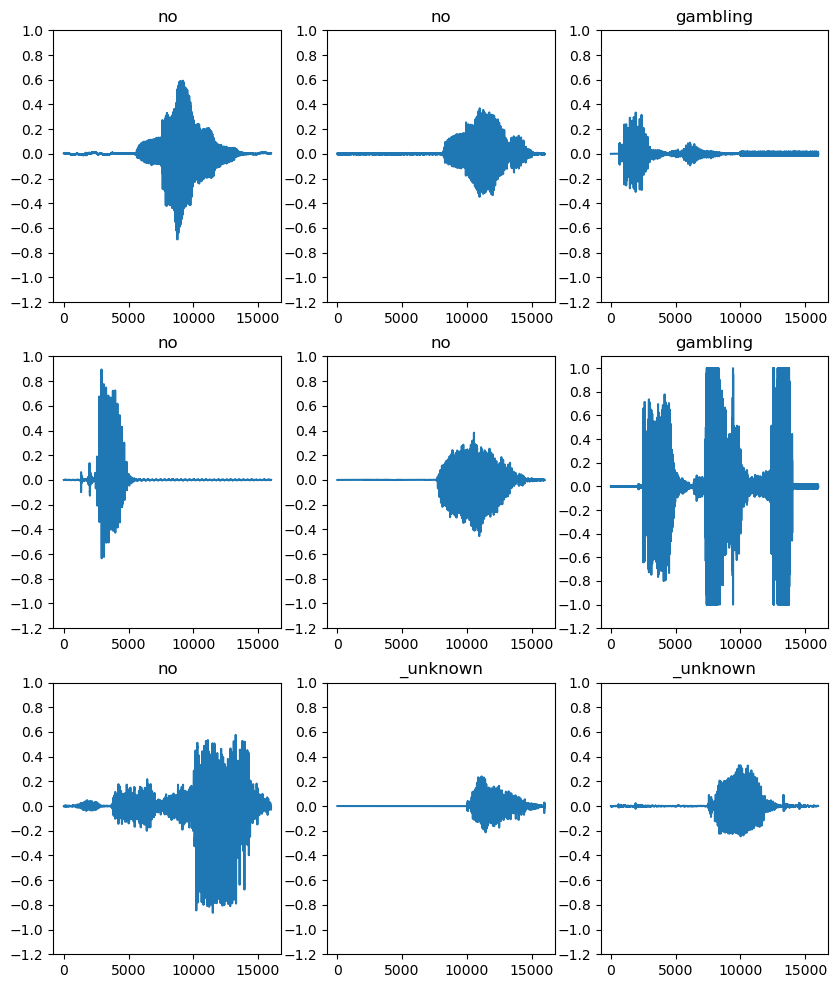

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [17]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (24, 32)
Audio playback


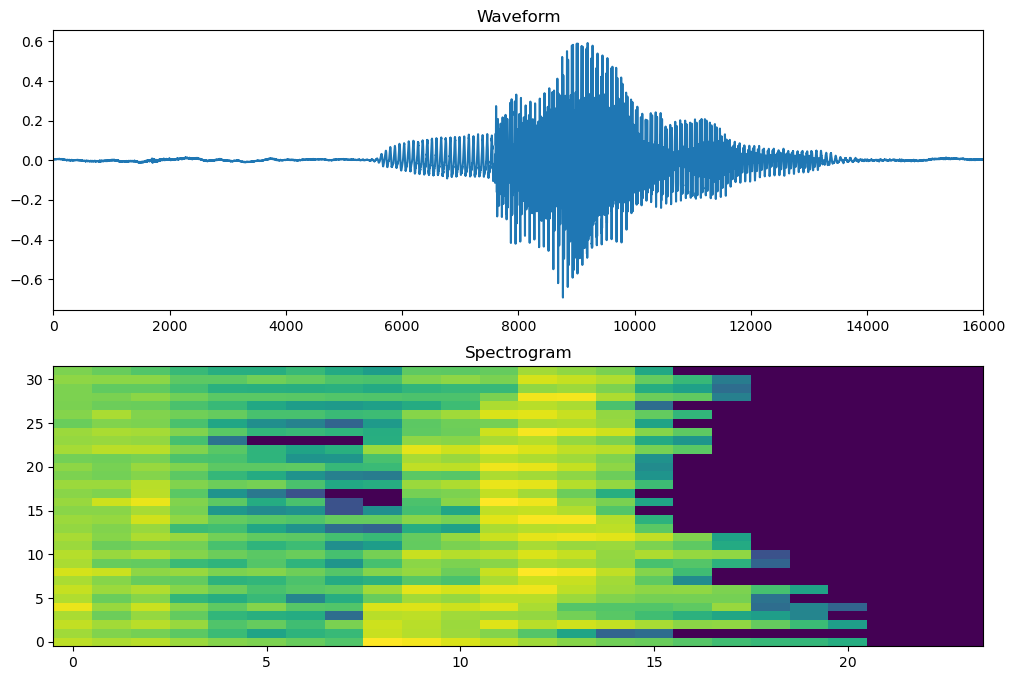

In [18]:
def plot_spectrogram(spectrogram, ax):
  # transpose so that the time is
  # represented in the x-axis (columns).
  freq_bins = spectrogram.shape[1]
  time_dur = spectrogram.shape[0]
  X = np.arange(time_dur)
  Y = range(freq_bins)
  ax.pcolormesh(X, Y, spectrogram.T)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [19]:
spectrogram.numpy().shape

(24, 32)

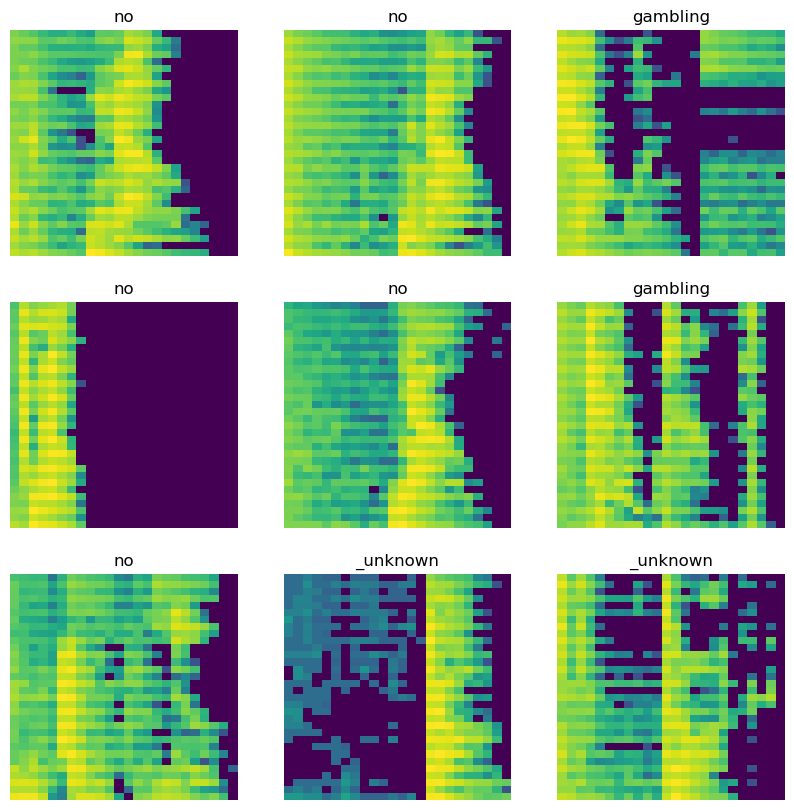

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(label_list[int(label_id)])
  ax.axis('off')

plt.show()

In [21]:
def copy_with_noise(ds_input, rms_level=0.25):
  rng = tf.random.Generator.from_seed(1234)
  wave_shape = tf.constant((wave_length_samps,))
  def add_noise(waveform, label):
    noise = rms_level*rng.normal(shape=wave_shape)
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)    
    noisy_wave = waveform + noise
    return noisy_wave, label

  return ds_input.map(add_noise)

In [22]:
# waveform_ds = augment_with_noise(waveform_ds)
count = 0
for w,l in waveform_ds:
  if w.shape != (16000,):
    print(f"element {count} has shape {w.shape}")
    break
  count += 1
print(count)

7987


In [23]:
def pad_16000(waveform, label):
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)        
    return waveform, label

In [24]:
def count_labels(dataset):
    counts = {}
    for _, lbl in dataset:
        if lbl.dtype == tf.string:
            label = lbl.numpy().decode('utf-8')
        else:
            label = lbl.numpy()
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

In [25]:
def ds_add_sample_weights(ds_input, weight_dict, default_weight=1.0):
  # build a tf hash table from the provided weight_dict
  table_init = tf.lookup.KeyValueTensorInitializer(
          # keys=tf.constant(, dtype=tf.string), # for string labels
          keys=tf.constant(list(weight_dict.keys()), dtype=tf.int32),
          values=tf.constant(list(weight_dict.values()), dtype=tf.float64)
          )
  weight_table = tf.lookup.StaticHashTable(table_init, 
        default_value=tf.constant(default_weight, dtype=tf.float64), 
        name="class_weight")
  # provide a mapping function to look up a weight and add it to the tuple
  def add_weight(value, label):
    # print("In add_weight. label is:")
    # print(label)
    weight = weight_table.lookup(tf.cast(label, dtype=tf.int32))
    return value, label, weight
  # actually map the dataset
  return ds_input.map(add_weight)

In [26]:
def strip_weights(ds_in):
    def strip_weights_sample(val, label, weight):
        return val, label

    for sample in ds_in.take(1):
        if len(sample) != 3:
            print(f"Sample should have 3 elements (input, label, weight), but only has {len(sample)}")
            print("This dataset appears not to have weights. Returning unmodified.")
            return(ds_in)
        
    return(ds_in.map(strip_weights_sample))

In [27]:
def is_batched(ds):
    ## This is probably not very robust
    try:
        ds.unbatch()  # does not actually change ds. For that we would ds=ds.unbatch()
    except:
        return False # we'll assume that the error on unbatching is because the ds is not batched.
    else:
        return True  # if we were able to unbatch it then it must have been batched (??)

In [28]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None):
  # if noisy_reps_of_known is not None, it should be a list of rms noise levels
  # For every target word in the data set, 1 copy will be created with each level 
  # of noise added to it.  So [0.1, 0.2] will add 2x noisy copies of the target words 
  if num_silent is None:
    num_silent = int(0.2*len(files))+1
  print(f"Processing {len(files)} files")
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  if noisy_reps_of_known is not None:
    # create a few copies of only the target words to balance the distribution
    # create a tmp dataset with only the target words
    ds_only_cmds = waveform_ds.filter(lambda w,l: tf.reduce_any(l == commands))
    for noise_level in noisy_reps_of_known:
       waveform_ds = waveform_ds.concatenate(copy_with_noise(ds_only_cmds, rms_level=noise_level))
  if num_silent > 0:
    silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps, 
                                            rms_noise_range=[0.01,0.2], 
                                            silent_label=silence_str)
    waveform_ds = waveform_ds.concatenate(silent_wave_ds)
  print(f"Added {num_silent} silent wavs and ?? noisy wavs")
  num_waves = 0
  output_ds = wavds2specds(waveform_ds)
  return output_ds

In [29]:
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

We have 7987/998/999 training/validation/test files


In [30]:
# print(train_files[:20])
print(label_list)
train_files[:20]

tmp_ds = preprocess_dataset(train_files[:20])
print(count_labels(tmp_ds))

if tf.test.is_gpu_available():
    device_name = '/GPU:0'
    print('Running on GPU')
else:
    device_name = '/CPU:0'
    print('Running on CPU')

with tf.device(device_name):
    tmp_ds = preprocess_dataset(train_files[:20], noisy_reps_of_known=[0.05,0.1])
    print(count_labels(tmp_ds))

['_silence', '_unknown', 'gambling', 'no']
Processing 20 files
Added 5 silent wavs and ?? noisy wavs
About to create spectrograms from 25 waves
 0 wavs processed{3: 10, 2: 4, 1: 6, 0: 5}
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Running on GPU
Processing 20 files
Added 5 silent wavs and ?? noisy wavs
About to create spectrograms from 53 waves
 0 wavs processed{3: 30, 2: 12, 1: 6, 0: 5}


In [31]:
if tf.test.is_gpu_available():
    device_name = '/GPU:0'
    print('Running on GPU')
else:
    device_name = '/CPU:0'
    print('Running on CPU')

with tf.device(device_name):
    train_ds = preprocess_dataset(train_files, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25])
    val_ds = preprocess_dataset(val_files)
    test_ds = preprocess_dataset(test_files)

Running on GPU
Processing 7987 files
Added 1598 silent wavs and ?? noisy wavs
About to create spectrograms from 35900 waves
 35750 wavs processedProcessing 998 files
Added 200 silent wavs and ?? noisy wavs
About to create spectrograms from 1198 waves
 1000 wavs processedProcessing 999 files
Added 200 silent wavs and ?? noisy wavs
About to create spectrograms from 1199 waves
 1000 wavs processed

In [32]:
print("Training data set")
print(count_labels(train_ds))
print("Validation data set")
print(count_labels(val_ds))
print("Test data set")
print(count_labels(test_ds))

Training data set
{3: 15138, 2: 16440, 1: 2724, 0: 1598}
Validation data set
{3: 327, 1: 323, 2: 348, 0: 200}
Test data set
{1: 347, 3: 294, 2: 358, 0: 200}


In [33]:
train_ds = train_ds.shuffle(int(len(train_files)*4))
val_ds = val_ds.shuffle(int(len(val_files)*1.2)+1)
test_ds = test_ds.shuffle(int(len(test_files)*1.2)+1)

train_counts = count_labels(train_ds)
valid_counts = count_labels(val_ds)
test_counts = count_labels(test_ds)

In [34]:
batch_size = 64

if not is_batched(train_ds):
    train_ds = train_ds.batch(batch_size)
if not is_batched(val_ds):
    val_ds = val_ds.batch(batch_size)
if not is_batched(test_ds):
    test_ds = test_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

In [35]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram.shape[1:]  
print('Input shape:', input_shape)
num_labels = len(label_list)

Input shape: (24, 32, 1)


In [36]:
for sample in train_ds.take(1):
  spec1 = sample[0]
# take(1) takes 1 *batch*, so we have to select the first 
# spectrogram from it, hence the [0]
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch

Spectrogram shape (24, 32, 1)
ranges from 0.0 to 712.0


In [39]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, DepthwiseConv2D, Dropout, MaxPooling2D, Flatten, Dense

In [40]:
def build_model(input_shape, num_labels, l2, lr):
    print('Input shape:', input_shape)
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(name='pool1'),

        layers.Conv2D(64, 3, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(name='pool2'),

        layers.Conv2D(128, 3, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(name='pool3'),

        layers.Flatten(),
        layers.Dense(256, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(128, kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(num_labels),
    ], name="modified_simple_cnn")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.01,
        patience=4,
        verbose=2,
        mode='max',
        restore_best_weights=True)

    return model, early_stopping


In [41]:
l2_value=0.0001
lr=0.001
EPOCHS=50
model, early_stopping = build_model(input_shape, num_labels,l2_value, lr)
model.summary()

Input shape: (24, 32, 1)
Model: "modified_simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 30, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 22, 30, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 22, 30, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 11, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 13, 64)         18496     
                                                                 
 batch_normalization_1 (Batc  (None, 9, 13, 64)        256       
 hNormalization)      

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import datetime


# Define the callbacks
checkpoint_callback = ModelCheckpoint(filepath='model.h5', monitor='val_accuracy', save_best_only=True)
tensorboard_callback = TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# Train the model with the callbacks
history = model.fit(train_ds, validation_data=val_ds, epochs=30,
                    callbacks=[early_stopping, checkpoint_callback, tensorboard_callback])


Epoch 1/10
561/561 [==============================] - 11s 11ms/step - loss: 0.5415 - accuracy: 0.8082 - val_loss: 0.9368 - val_accuracy: 0.7496
Epoch 2/10
561/561 [==============================] - 5s 10ms/step - loss: 0.3339 - accuracy: 0.8904 - val_loss: 0.5315 - val_accuracy: 0.7896
Epoch 3/10
561/561 [==============================] - 6s 10ms/step - loss: 0.2650 - accuracy: 0.9208 - val_loss: 0.2545 - val_accuracy: 0.9441
Epoch 4/10
561/561 [==============================] - 7s 12ms/step - loss: 0.2162 - accuracy: 0.9414 - val_loss: 0.6256 - val_accuracy: 0.8139
Epoch 5/10
561/561 [==============================] - 7s 12ms/step - loss: 0.1822 - accuracy: 0.9544 - val_loss: 0.9986 - val_accuracy: 0.7437
Epoch 6/10
561/561 [==============================] - 7s 12ms/step - loss: 0.1640 - accuracy: 0.9616 - val_loss: 0.6783 - val_accuracy: 0.8155
Epoch 7/10
561/561 [==============================] - 6s 11ms/step - loss: 0.1459 - accuracy: 0.9695 - val_loss: 0.3157 - val_accuracy: 0.914

In [53]:
model_file_name = f"model.h5" 
print(f"Saving model to {model_file_name}")
model.save(model_file_name, overwrite=False)

Saving model to model.h5
[TIP] Next time specify overwrite=True!


In [54]:
## Measure test-set accuracy manually and get values for confusion matrix
test_audio = []
test_labels = []
if is_batched(test_ds):
  was_batched=True
  test_ds = test_ds.unbatch()
else:
  was_batched=False
for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

model_out = model.predict(test_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.1%}')
if was_batched:
  test_ds = test_ds.batch(32)

38/38 [==============================] - 0s 5ms/step
Test set accuracy: 93.8%


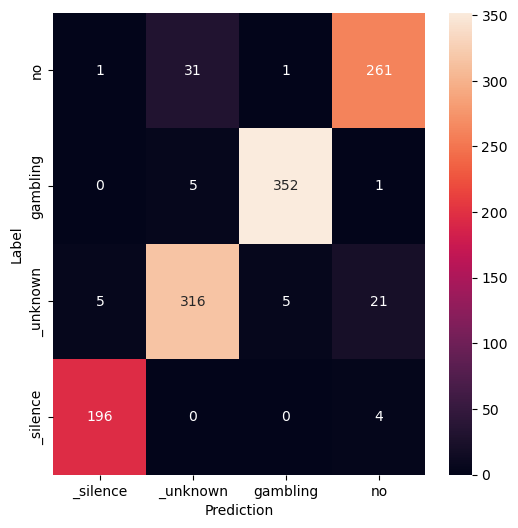

In [55]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [56]:
tpr = np.nan*np.zeros(len(label_list))
fpr = np.nan*np.zeros(len(label_list))
for i in range(4):
    tpr[i]  = confusion_mtx[i,i] / np.sum(confusion_mtx[i,:])
    fpr[i] = (np.sum(confusion_mtx[:,i]) - confusion_mtx[i,i]) / \
      (np.sum(confusion_mtx) - np.sum(confusion_mtx[i,:]))
    print(f"True/False positive rate for '{label_list[i]:9}' = {tpr[i]:.3} / {fpr[i]:.3}")


True/False positive rate for '_silence ' = 0.98 / 0.00601
True/False positive rate for '_unknown ' = 0.911 / 0.0423
True/False positive rate for 'gambling ' = 0.983 / 0.00713
True/False positive rate for 'no       ' = 0.888 / 0.0287


In [58]:
with open(model_file_name.split('.')[0] + '.txt', 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")
    fpo.write(f"Test set accuracy =  {test_acc:.1%}\n")
    for i in range(4):
        fpo.write(f"tpr_{label_list[i]:9} = {tpr[i]:.3}\n")
        fpo.write(f"fpr_{label_list[i]:9} = {fpr[i]:.3}\n")


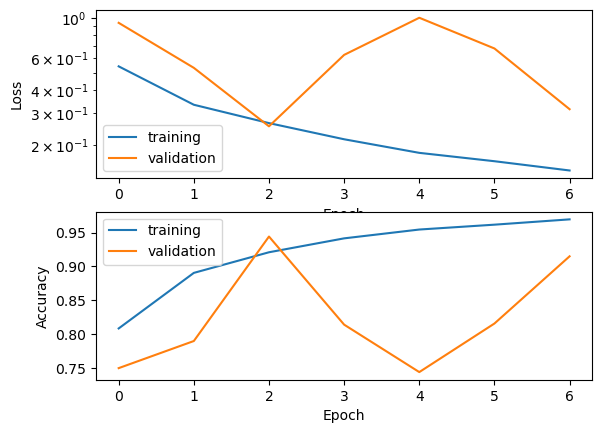

In [59]:
metrics = history.history
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

On training set:
ds_labels[0] = 3
<class 'list'>
1122/1122 [==============================] - 3s 3ms/step
Data set accuracy: 84%


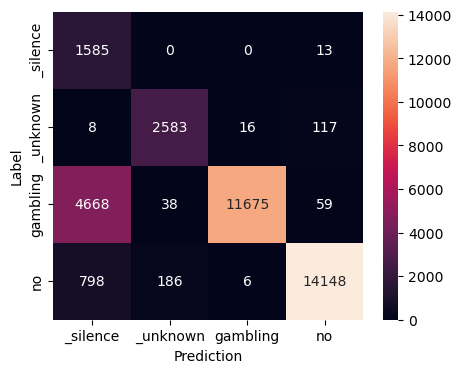

In [60]:
dset = train_ds.unbatch()
print("On training set:")

ds_audio = []
ds_labels = []

for sample in dset:
  audio, label = sample[0], sample[1]
  ds_audio.append(audio.numpy())
  ds_labels.append(label.numpy())

print(f"ds_labels[0] = {ds_labels[0]}")
print(type(ds_labels))
ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model.predict(ds_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

ds_labels[0] = 3
<class 'list'>
38/38 [==============================] - 0s 3ms/step


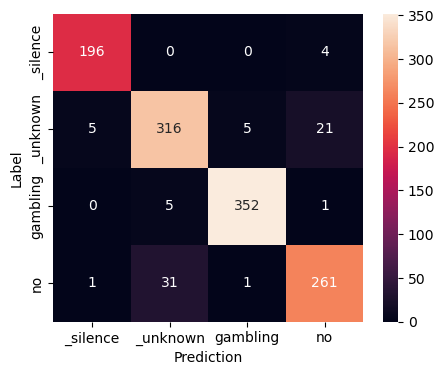

In [61]:
def get_confusion_matrix(dset, model):
    # if is_batched(dset):
    #     dset = dset.unbatch()

    ds_audio = []
    ds_labels = []

    if is_batched(dset):
      dset = dset.unbatch()
  
    for sample in dset:
      audio, label = sample[0], sample[1]
      ds_audio.append(audio.numpy())
      ds_labels.append(label.numpy())

    print(f"ds_labels[0] = {ds_labels[0]}")
    print(type(ds_labels))

    ds_labels = np.array(ds_labels)
    ds_audio = np.array(ds_audio)

    model_out = model.predict(ds_audio)
    y_pred = np.argmax(model_out, axis=1)
    y_true = ds_labels

    # ds_acc = sum(y_pred == y_true) / len(y_true)
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
    return confusion_mtx

# print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = get_confusion_matrix(test_ds, model)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [62]:
import tensorflow as tf

# Step 1: Load the HDF5 model
model_file_name = "model.h5"  # Update with your HDF5 model file name
model = tf.keras.models.load_model(model_file_name)


In [63]:
# Convert the trained model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model to a file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

# Specify the destination directory where you want to copy the TensorFlow Lite model
destination_directory = r"C:\Users\diego\OneDrive\Desktop\ML IoT\Project 2"

# Copy the TensorFlow Lite model to the destination directory
shutil.copy(tflite_filename, destination_directory)  

INFO:tensorflow:Assets written to: C:\Users\diego\AppData\Local\Temp\tmpx9ppq7qn\assets


INFO:tensorflow:Assets written to: C:\Users\diego\AppData\Local\Temp\tmpx9ppq7qn\assets


NameError: name 'shutil' is not defined

In [64]:
def tflite_to_cc(tflite_filename, cc_filename):
    # Read the binary contents of the TensorFlow Lite model file
    with open(tflite_filename, "rb") as f:
        tflite_model_data = f.read()

    # Convert the binary data to a C array string
    c_array_str = ", ".join([f"0x{byte:02X}" for byte in tflite_model_data])

    # Write the C array string to the C++ source file
    with open(cc_filename, "w") as f:
        f.write("const unsigned char g_model [] DATA_ALIGN_ATTRIBUTE= {")
        
        # Write the C array string, limiting each line to 12 elements
        for i in range(0, len(c_array_str), 12*6):
            f.write("\n    ")
            f.write(c_array_str[i:i+12*6])
            

        f.write("\n};\n\n")
        f.write(f"const int g_model_len = {len(tflite_model_data)};\n\n")


    print(f"Successfully converted {tflite_filename} to {cc_filename}")
    print(f"Length of TensorFlow Lite model data: {len(tflite_model_data)} bytes")

# Example usage:
tflite_to_cc("model.tflite", "model_data.cc")

Successfully converted model.tflite to model_data.cc
Length of TensorFlow Lite model data: 773140 bytes
